In [ ]:
import os
import time
import random
from glob import glob

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim


from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.models as models
import torchvision.utils as vutils
from torchvision import transforms
from torchvision.transforms import functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = sorted(os.listdir(lr_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr = Image.open(lr_path).convert("RGB")
        hr = Image.open(hr_path).convert("RGB")


        # Convert to tensor
        lr = TF.to_tensor(lr)
        hr = TF.to_tensor(hr)

        return lr, hr


class HROnlyDataset(Dataset):
    def __init__(self, hr_dir, transform=None):
        self.hr_paths = sorted([os.path.join(hr_dir, fname) for fname in os.listdir(hr_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr_img = Image.open(self.hr_paths[idx]).convert("RGB")
        if self.transform:
            hr_img = self.transform(hr_img)
        return hr_img, hr_img


lr_dir="/kaggle/input/satellite-super-resolution-khazani/lr/lr"
hr_dir="/kaggle/input/satellite-super-resolution-khazani/hr/hr"
dataset = SRDataset(lr_dir, hr_dir)
val_size = int(0.01* len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
val_batch = next(iter(val_loader))
transform = transforms.Compose([
    transforms.ToTensor()
])
hr_dataset = HROnlyDataset(hr_dir, transform=transform)
hr_loader = DataLoader(hr_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial convolution layer
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(5)])

        # Post-residual block convolution
        self.conv_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )

        # Upsample to 5x using bicubic interpolation followed by a learned convolution
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=5, mode='bicubic', align_corners=False),  # Bicubic interpolation (5x scaling)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Refine with a convolution
            nn.PReLU()
        )

        # Final convolution to match output channels (3 for RGB image)
        self.final = nn.Sequential(
          nn.Conv2d(64, 3, kernel_size=9, padding=4),
          nn.Sigmoid()
        )


    def forward(self, x):
        # Initial feature extraction
        initial = self.initial(x)

        # Residual blocks
        x = self.res_blocks(initial)

        # Post-residual block convolution
        x = self.conv_block(x)

        # Add the initial input (skip connection)
        x = x + initial

        # Upsample and refine
        x = self.upsample(x)

        # Final output (super-resolved image)
        return self.final(x)

In [ ]:
class SmallerDiscriminator(nn.Module):
    def __init__(self, img_size=250):
        super(SmallerDiscriminator, self).__init__()

        def disc_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            disc_block(64, 64, stride=2),    # 250 → 125
            disc_block(64, 128, stride=1),
            disc_block(128, 128, stride=2),  # 125 → 63
            disc_block(128, 256, stride=1),
            disc_block(256, 256, stride=2),  # 63 → 32
            disc_block(256, 512, stride=1),
            disc_block(512, 512, stride=2),  # 32 → 16
        )

        self.final = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),   # (512, 1, 1)
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()  # Output: real/fake probability
        )

    def forward(self, x):
        x = self.features(x)
        x = self.final(x)
        return x

In [ ]:
class CustomVGGBlock4(nn.Module):
    def __init__(self):
        super(CustomVGGBlock4, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 125x125

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 62x62

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 31x31

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 15*15
        )

    def forward(self, x):
        return self.features(x)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 15 -> 30
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 30 -> 60
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 60 -> 120
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # 120 -> 240
            nn.ReLU(True),

            nn.Upsample(size=(250, 250), mode='bilinear', align_corners=False),  # final 240 -> 250

            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # final RGB conversion
            nn.Sigmoid()  # keep pixel range between [0, 1]
        )

    def forward(self, x):
        return self.decode(x)


In [ ]:

encoder = CustomVGGBlock4().to(device)
decoder = Decoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

num_epochs = 25

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    running_loss = 0.0

    for inputs, targets in hr_loader:  # inputs == targets here
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        features = encoder(inputs)         # encode
        outputs = decoder(features)        # decode / reconstruct

        loss = criterion(outputs, targets) # compute reconstruction loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

   epoch_loss = running_loss / len(hr_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save encoder weights after training
torch.save(encoder.state_dict(), 'encoder_weights.pth')

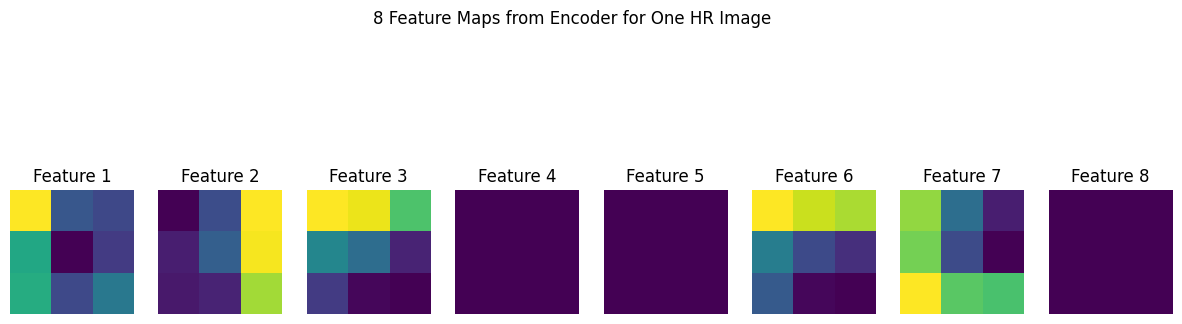

In [ ]:
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure your model is on device and in eval mode
model = encoder.to(device).eval()

# Get one batch and pick one HR image
hr_batch, _ = next(iter(train_loader))  # assume train_loader gives (HR, something)
hr_img = hr_batch[0].unsqueeze(0).to(device)  # shape: [1, 3, H, W]

with torch.no_grad():
    features = model(hr_img)  # features shape: [1, C, H_f, W_f]

# If output is a tuple or list, get the last or appropriate feature tensor
if isinstance(features, (list, tuple)):
    features = features[-1]

# Clamp to max 8 channels
num_feature_maps = min(8, features.shape[1])

# Plot feature maps (grayscale)
plt.figure(figsize=(15, 5))
for i in range(num_feature_maps):
    plt.subplot(1, num_feature_maps, i + 1)
    # squeeze batch dimension, pick channel i
    fmap = features[0, i].cpu()
    plt.imshow(fmap, cmap='viridis')
    plt.axis('off')
    plt.title(f'Feature {i+1}')

plt.suptitle("8 Feature Maps from Encoder for One HR Image")
plt.show()




In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

encoder = CustomVGGBlock4()
decoder = Decoder()

print(f"Encoder parameters: {count_parameters(encoder):,}")
print(f"Decoder parameters: {count_parameters(decoder):,}")

Encoder parameters: 10,585,152
Decoder parameters: 1,568,067


In [ ]:
def pretrain_ssresnet(generator, dataloader, device, epochs=10):
    generator = generator.to(device)
    generator.train()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0

        for lr, hr in tqdm(dataloader, desc=f"Pretrain SRResNet Epoch {epoch+1}/{epochs}"):
            lr = lr.to(device)
            hr = hr.to(device)

            sr = generator(lr)
            loss = criterion(sr, hr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        print(f"[Pretrain Epoch {epoch+1}] Avg Pixel Loss: {avg_loss:.4f}")

        # Optional: Save intermediate weights
        torch.save(generator.state_dict(), f"/kaggle/working/ssresnet_pretrain_epoch{epoch+1}.pth")



In [ ]:
generator=Generator()
pretrain_ssresnet(generator, train_loader, device, epochs=30)


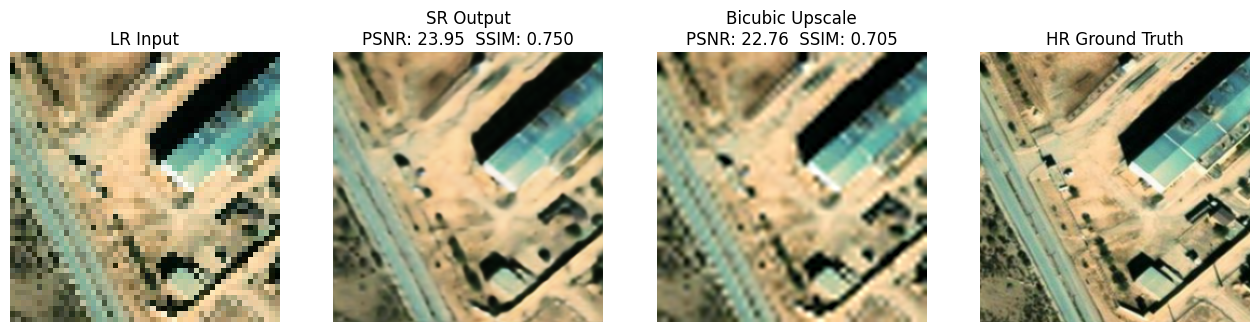

In [ ]:
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

# Get one batch of validation data
lr_batch, hr_batch = next(iter(val_loader))
hr_img = hr_batch[0].unsqueeze(0).to(device)  # single HR image with batch dimension
lr_img = lr_batch[0].unsqueeze(0).to(device)  # single LR image with batch dimension

# Inference
model = generator.to(device)
model.eval()
with torch.no_grad():
    sr_img = model(lr_img)           # SR output
    sr_img = sr_img.squeeze(0).cpu() # remove batch dim, back to CPU

# Bicubic upscale LR to HR size
bicubic_img = F.interpolate(lr_img, size=hr_img.shape[2:], mode='bicubic', align_corners=False)
bicubic_img = bicubic_img.squeeze(0).cpu()

# Convert tensors [C,H,W] to [H,W,C] and clamp to [0,1]
def to_np(img_tensor):
    return img_tensor.cpu().permute(1, 2, 0).clamp(0, 1).numpy()

# Convert all images
lr_np = to_np(lr_img.squeeze(0))
sr_np = to_np(sr_img)
bicubic_np = to_np(bicubic_img)
hr_np = to_np(hr_img.squeeze(0))

# Compute PSNR and SSIM for SR image
psnr_sr = compare_psnr(hr_np, sr_np, data_range=1.0)
ssim_sr = compare_ssim(hr_np, sr_np, data_range=1.0, channel_axis=2)

# Compute PSNR and SSIM for bicubic image
psnr_bicubic = compare_psnr(hr_np, bicubic_np, data_range=1.0)
ssim_bicubic = compare_ssim(hr_np, bicubic_np, data_range=1.0, channel_axis=2)

# Plot results
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title('LR Input')
plt.imshow(lr_np)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title(f'SR Output\nPSNR: {psnr_sr:.2f}  SSIM: {ssim_sr:.3f}')
plt.imshow(sr_np)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title(f'Bicubic Upscale\nPSNR: {psnr_bicubic:.2f}  SSIM: {ssim_bicubic:.3f}')
plt.imshow(bicubic_np)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('HR Ground Truth')
plt.imshow(hr_np)
plt.axis('off')

plt.show()


In [ ]:
def tensor_to_np(tensor):
    """Convert torch tensor [C,H,W] to numpy [H,W,C]"""
    return tensor.detach().cpu().clamp(0,1).permute(1, 2, 0).numpy()

def show_comparison(lr_img, sr_img, bicubic_img, hr_img):
    plt.figure(figsize=(16, 4))
    imgs = [lr_img, bicubic_img, sr_img, hr_img]
    titles = ['LR Input', 'Bicubic Upsample', 'SRGAN Output', 'HR Ground Truth']

    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def compute_metrics(lr_tensor, hr_tensor, generator, device):
    generator.eval()
    with torch.no_grad():
        # Ensure batch dimension
        if lr_tensor.dim() == 3:
            lr_tensor = lr_tensor.unsqueeze(0)
        if hr_tensor.dim() == 3:
            hr_tensor = hr_tensor.unsqueeze(0)

        lr_tensor = lr_tensor.to(device)
        hr_tensor = hr_tensor.to(device)

        sr_tensor = generator(lr_tensor)
        bicubic_tensor = F.interpolate(lr_tensor, size=hr_tensor.shape[-2:], mode='bicubic', align_corners=False)

        sr_img = tensor_to_np(sr_tensor.squeeze(0))
        bicubic_img = tensor_to_np(bicubic_tensor.squeeze(0))
        hr_img = tensor_to_np(hr_tensor.squeeze(0))

        psnr_sr = psnr(hr_img, sr_img, data_range=1.0)
        psnr_bicubic = psnr(hr_img, bicubic_img, data_range=1.0)

        ssim_sr = ssim(hr_img, sr_img, data_range=1.0, channel_axis=2)
        ssim_bicubic = ssim(hr_img, bicubic_img, data_range=1.0, channel_axis=2)

    generator.train()
    return {
        "PSNR_SR": psnr_sr,
        "PSNR_Bicubic": psnr_bicubic,
        "SSIM_SR": ssim_sr,
        "SSIM_Bicubic": ssim_bicubic
    }

def train_srgan_paper(generator, discriminator, feature_extractor, dataloader, device, epochs=50, val_batch=None, save_path="./"):
    g = generator.to(device)
    d = discriminator.to(device)
    f = feature_extractor.to(device)

    f.eval()
    for param in f.parameters():
        param.requires_grad = False

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    opt_g = optim.Adam(g.parameters(), lr=1e-4)
    opt_d = optim.Adam(d.parameters(), lr=1e-4)

    for epoch in range(epochs):
        g.train()
        d.train()

        total_content_loss = 0.0
        total_adv_loss = 0.0
        total_g_loss = 0.0
        total_d_loss = 0.0
        num_batches = 0

        for lr_imgs, hr_imgs in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            ###### Train Discriminator ######
            with torch.no_grad():
                sr_imgs = g(lr_imgs)

            real_preds = d(hr_imgs)
            fake_preds = d(sr_imgs)

            loss_d_real = bce_loss(real_preds, torch.ones_like(real_preds))
            loss_d_fake = bce_loss(fake_preds, torch.zeros_like(fake_preds))
            loss_d = (loss_d_real + loss_d_fake) * 0.5

            opt_d.zero_grad()
            loss_d.backward()
            opt_d.step()

            ###### Train Generator ######
            sr_imgs = g(lr_imgs)
            fake_preds = d(sr_imgs)

            adv_loss = bce_loss(fake_preds, torch.ones_like(fake_preds))

            features_sr = f(sr_imgs)
            features_hr = f(hr_imgs).detach()
            content_loss = mse_loss(features_sr, features_hr)

            loss_g = content_loss + 0.1 * adv_loss

            opt_g.zero_grad()
            loss_g.backward()
            opt_g.step()

            total_content_loss += content_loss.item()
            total_adv_loss += adv_loss.item()
            total_g_loss += loss_g.item()
            total_d_loss += loss_d.item()
            num_batches += 1

        print(f"[Epoch {epoch+1}] "
              f"Loss_D: {total_d_loss / num_batches:.4f}, "
              f"Content_Loss: {total_content_loss / num_batches:.4f}, "
              f"Adv_Loss: {total_adv_loss / num_batches:.6f}, "
              f"Total_G_Loss: {total_g_loss / num_batches:.4f}")

        # Validation & visualization
        if val_batch is not None:
            lr_val, hr_val = val_batch
            metrics = compute_metrics(lr_val, hr_val, g, device)
            print(f"Epoch {epoch+1} Metrics: PSNR_SR={metrics['PSNR_SR']:.4f}, PSNR_Bicubic={metrics['PSNR_Bicubic']:.4f}, "
                  f"SSIM_SR={metrics['SSIM_SR']:.4f}, SSIM_Bicubic={metrics['SSIM_Bicubic']:.4f}")

            show_comparison(
                tensor_to_np(lr_val[0]),
                tensor_to_np(g(lr_val.to(device))[0]),
                tensor_to_np(F.interpolate(lr_val.to(device), size=hr_val.shape[-2:], mode='bicubic', align_corners=False)[0]),
                tensor_to_np(hr_val[0])
            )

        # Save models
        save_path='/kaggle/working/'
        torch.save(g.state_dict(), f"{save_path}/generator_epoch{epoch+1}.pth")
        torch.save(d.state_dict(), f"{save_path}/discriminator_epoch{epoch+1}.pth")

Epoch 1/25: 100%|██████████| 1779/1779 [36:23<00:00,  1.23s/it]


[Epoch 1] Loss_D: 0.5056, Content_Loss: 1.0576, Adv_Loss: 1.430584, Total_G_Loss: 1.2006
Epoch 1 Metrics: PSNR_SR=22.6770, PSNR_Bicubic=22.7620, SSIM_SR=0.6830, SSIM_Bicubic=0.7045


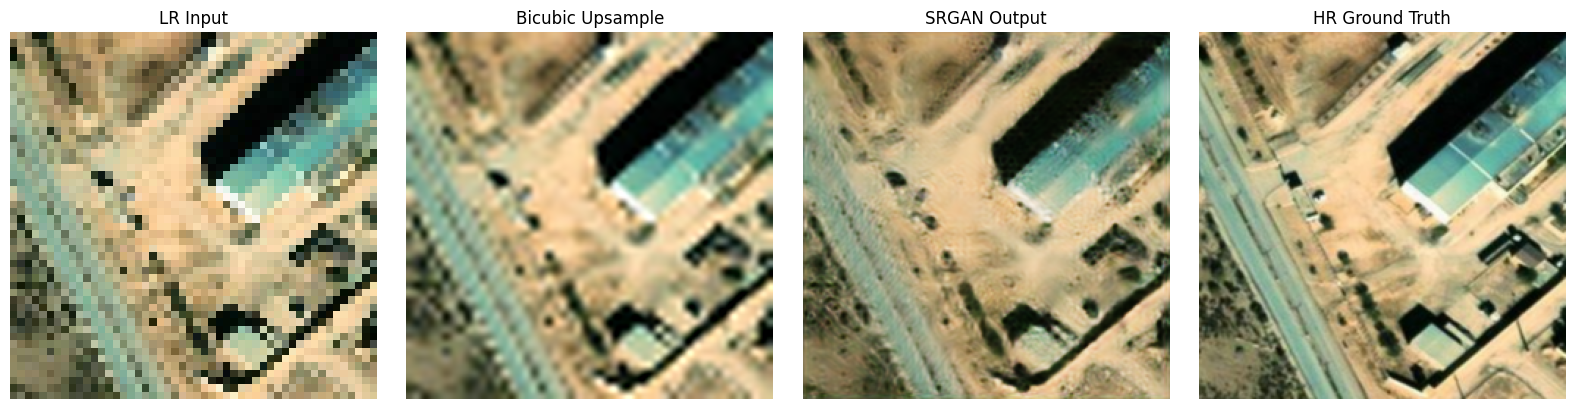

Epoch 2/25:  38%|███▊      | 684/1779 [13:59<22:27,  1.23s/it]

In [ ]:
discriminator=SmallerDiscriminator(img_size=250)
feature_extractor=encoder.to(device).eval()



train_srgan_paper(generator, discriminator, feature_extractor, train_loader, device, epochs=2, val_batch=val_batch, save_path="./models")
